In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = 'healthcare-dataset-stroke-data (2).csv'
df = pd.read_csv(data_path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df_edit = df.drop(columns=['id'])
print(len(df_edit))


5110


In [ ]:
from imblearn.combine import SMOTETomek

# Instantiate SMOTETomek
smote_tomek = SMOTETomek(random_state=42)

# Separate features and target
X = df_edit.drop(columns=['stroke'])  # Features
y = df_edit['stroke']  # Target variable

# Apply SMOTETomek
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Combine resampled features and target into one DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['stroke'])], axis=1)

# Check the new DataFrame
print(df_resampled.head())
print(df_resampled['stroke'].value_counts())  # Check class distribution

In [4]:
# count nulls
df_edit.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Only 248 out of 5044 have strokes, with 40 of those having a BMI of null, that's 15% of all people with strokes. We cant just remove them out of the database.
We need to take another approach..

In [5]:
df_edit['bmi'].fillna(df_edit['bmi'].mean(), inplace=True)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_9736\2221578010.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_edit['bmi'].fillna(df_edit['bmi'].mean(), inplace=True)


In [6]:
df_edit.describe(percentiles=[.25, .5, .75,.9, .88, .99])

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
88%,72.000000,0.000000,0.000000,172.325200,37.500000,0.000000
90%,75.000000,0.000000,0.000000,192.181000,38.700000,0.000000
99%,82.000000,1.000000,1.000000,240.708200,52.891000,1.000000


In [7]:
# Define thresholds for outliers
bmi_mean, bmi_std = 29, 7.6
glucose_mean, glucose_std = 106, 45

bmi_lower, bmi_upper = bmi_mean - 3 * bmi_std, bmi_mean + 3 * bmi_std
glucose_lower, glucose_upper = glucose_mean - 3 * glucose_std, glucose_mean + 3 * glucose_std

print(f"BMI Outlier Range: Below {bmi_lower:.2f} or Above {bmi_upper:.2f}")
print(f"Glucose Outlier Range: Below {glucose_lower:.2f} or Above {glucose_upper:.2f}")

# Identify outliers for BMI and glucose levels
bmi_outliers = df_edit[(df_edit['bmi'] <= bmi_lower) | (df_edit['bmi'] >= bmi_upper)]
glucose_outliers = df_edit[(df_edit['avg_glucose_level'] < glucose_lower) | (df_edit['avg_glucose_level'] > glucose_upper)]

# Count total outliers and stroke cases among them
bmi_stroke_cases = bmi_outliers[bmi_outliers['stroke'] > 0].shape[0]
glucose_stroke_cases = glucose_outliers[glucose_outliers['stroke'] > 0].shape[0]

print(f"Total BMI Outliers: {bmi_outliers.shape[0]}, Stroke Cases: {bmi_stroke_cases}")
print(f"Total Glucose Outliers: {glucose_outliers.shape[0]}, Stroke Cases: {glucose_stroke_cases}")
df_cleaned = df_edit[(df_edit['bmi'] >= bmi_lower) & (df_edit['bmi'] <= bmi_upper)]
print("removing 62 BMI outliers...")
print(len(df_edit))
print(len(df_cleaned))

BMI Outlier Range: Below 6.20 or Above 51.80
Glucose Outlier Range: Below -29.00 or Above 241.00
Total BMI Outliers: 62, Stroke Cases: 1
Total Glucose Outliers: 49, Stroke Cases: 9
removing 62 BMI outliers...
5110
5049


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5049 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5049 non-null   object 
 1   age                5049 non-null   float64
 2   hypertension       5049 non-null   int64  
 3   heart_disease      5049 non-null   int64  
 4   ever_married       5049 non-null   object 
 5   work_type          5049 non-null   object 
 6   Residence_type     5049 non-null   object 
 7   avg_glucose_level  5049 non-null   float64
 8   bmi                5049 non-null   float64
 9   smoking_status     5049 non-null   object 
 10  stroke             5049 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 473.3+ KB


In [9]:
#count the number of rows with stroke>0
df_cleaned[df_edit['stroke'] > 0].shape[0]

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9736\3152572755.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned[df_edit['stroke'] > 0].shape[0]


248

Correlation between BMI and Stroke: 0.05


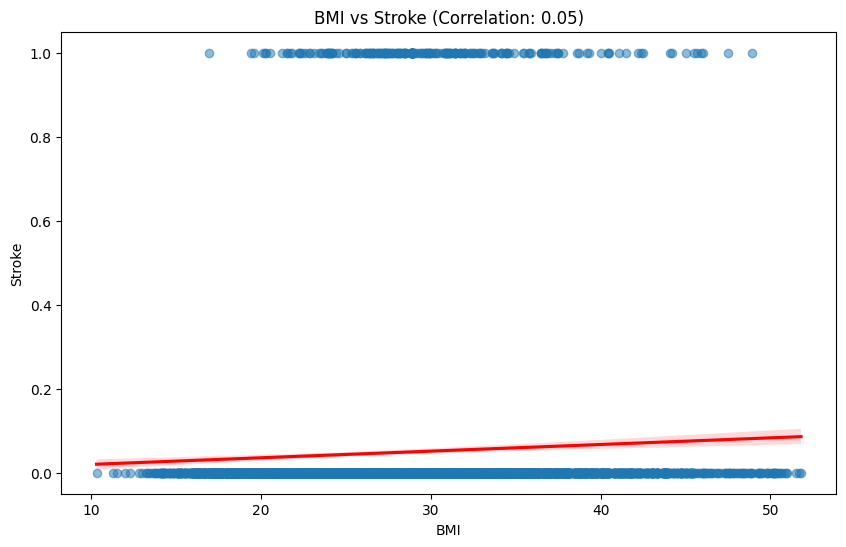

In [16]:
# Calculate the correlation coefficient
correlation = df_cleaned[['bmi', 'stroke']].corr().iloc[0, 1]
print(f"Correlation between BMI and Stroke: {correlation:.2f}")

# Visualize the correlation using a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='bmi', y='stroke', data=df_cleaned, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title(f'BMI vs Stroke (Correlation: {correlation:.2f})')
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.show()

In [11]:
df_encoded = pd.get_dummies(df_cleaned, drop_first=True).astype(np.float64)
df_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0.0,1.0,228.69,36.600000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,61.0,0.0,0.0,202.21,28.893237,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0.0,1.0,105.92,32.500000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0.0,0.0,171.23,34.400000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.0,1.0,0.0,174.12,24.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
correlation_matrix = df_encoded.corr()
print(correlation_matrix['stroke'].sort_values(ascending=False))
print()
print(correlation_matrix['age'].sort_values(ascending=False))
print()
print(correlation_matrix['ever_married_Yes'].sort_values(ascending=False))

stroke                            1.000000
age                               0.246577
heart_disease                     0.135255
avg_glucose_level                 0.132395
hypertension                      0.131999
ever_married_Yes                  0.109208
smoking_status_formerly smoked    0.065573
work_type_Self-employed           0.062808
bmi                               0.051089
Residence_type_Urban              0.016338
work_type_Private                 0.012014
smoking_status_smokes             0.009350
gender_Male                       0.009203
gender_Other                     -0.003199
smoking_status_never smoked      -0.005134
work_type_Never_worked           -0.015035
work_type_children               -0.084852
Name: stroke, dtype: float64

age                               1.000000
ever_married_Yes                  0.681017
bmi                               0.359441
work_type_Self-employed           0.328650
hypertension                      0.278830
heart_disease           

Typically, features with stroke correlation below 0.1 are unwanted and may be removed, but we need to do further inspection before we remove them.

c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


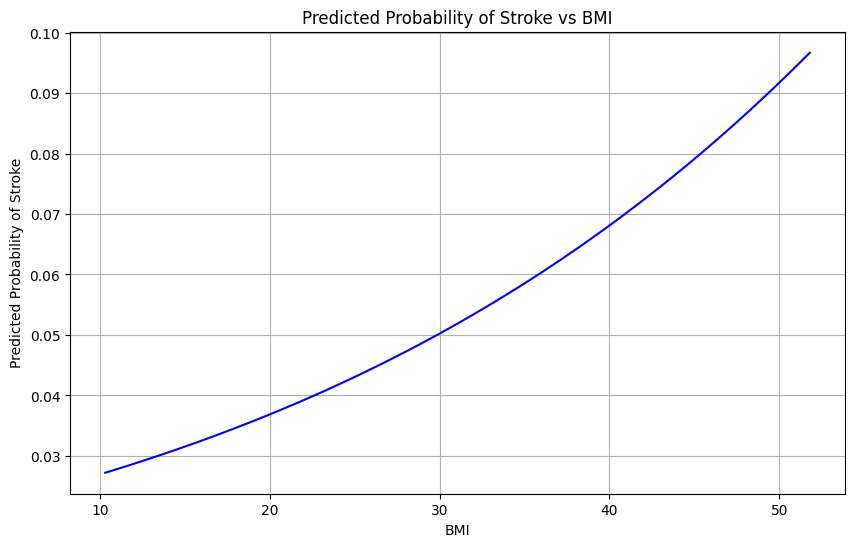

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(df_encoded[['bmi']], df_encoded['stroke'])
# Predict the probability of stroke for a range of BMI values
bmi_values = np.linspace(df_encoded['bmi'].min(), df_encoded['bmi'].max(), 100).reshape(-1, 1)
predicted_probabilities = model.predict_proba(bmi_values)[:, 1]
# Plot the predicted probabilities against BMI values
plt.figure(figsize=(10, 6))
plt.plot(bmi_values, predicted_probabilities, color='blue')
plt.title('Predicted Probability of Stroke vs BMI')
plt.xlabel('BMI')
plt.ylabel('Predicted Probability of Stroke')
plt.grid()
plt.show()


Correlation matrix showed that BMI is uncorrelated with strokes, but the logistic regression model tells a different story, we will leave BMI for now. 

c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


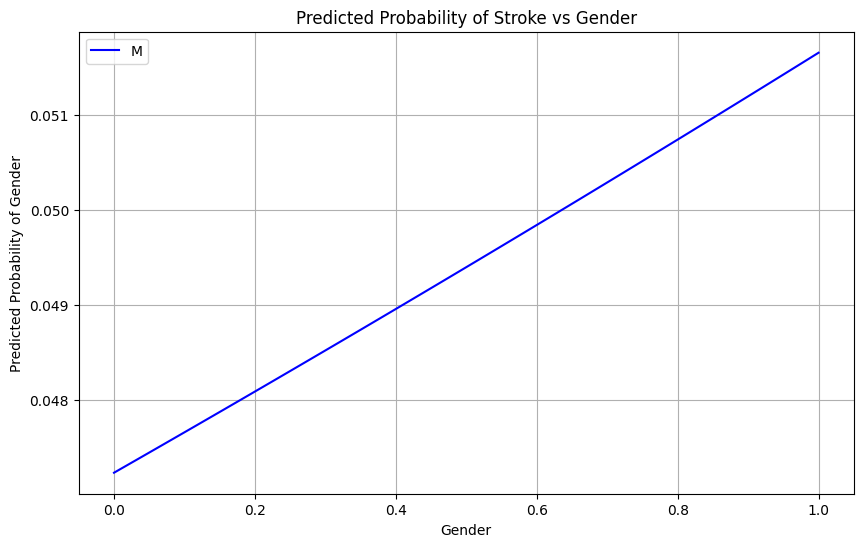

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(df_encoded[['gender_Male']], df_encoded['stroke'])
# Predict the probability of stroke for a range of BMI values
bmi_values = np.linspace(df_encoded['gender_Male'].min(), df_encoded['gender_Male'].max(), 100).reshape(-1, 1)
predicted_probabilities = model.predict_proba(bmi_values)[:, 1]
# Plot the predicted probabilities against BMI values
plt.figure(figsize=(10, 6))
plt.plot(bmi_values, predicted_probabilities, color='blue')
plt.title('Predicted Probability of Stroke vs Gender')
plt.xlabel('Gender')
plt.ylabel('Predicted Probability of Gender')
plt.legend("Male = 1, Female = 0")
plt.grid()
plt.show()


As we can see, difference in probability between stroke cases in males and females is a mere 0.04%. This feature does not contribute much to our prediction and can therefore be dropped.

c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


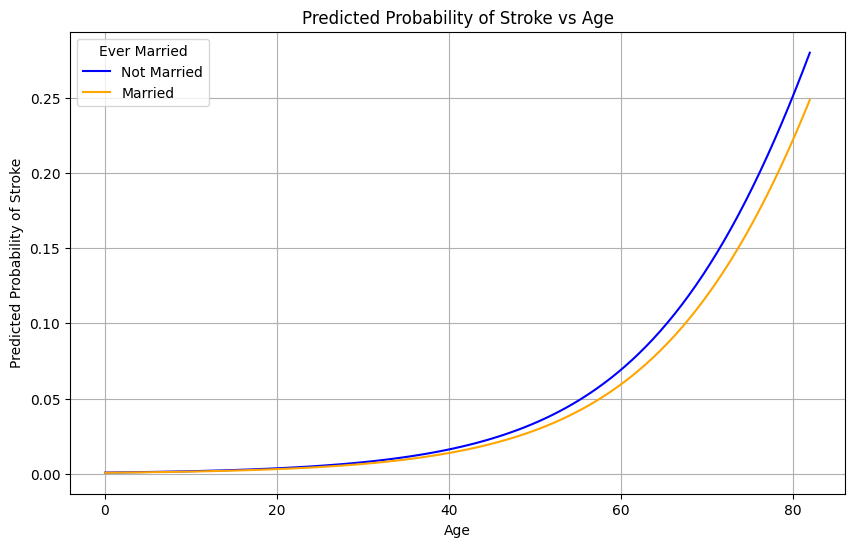

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prepare the data
X = df_encoded[['age', 'ever_married_Yes']]  # Features
y = df_encoded['stroke']  # Target variable

# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X, y)

# Generate a range of ages for prediction
age_range = np.linspace(df_encoded['age'].min(), df_encoded['age'].max(), 100)

# Create a DataFrame for predictions
probabilities = []
for married_status in [0, 1]:  # 0 for No, 1 for Yes
    age_married = np.column_stack((age_range, np.full_like(age_range, married_status)))
    predicted_probs = model.predict_proba(age_married)[:, 1]  # Probability of stroke (class 1)
    probabilities.append(predicted_probs)

# Plot the predicted probabilities
plt.figure(figsize=(10, 6))
plt.plot(age_range, probabilities[0], label='Not Married', color='blue')
plt.plot(age_range, probabilities[1], label='Married', color='orange')
plt.title('Predicted Probability of Stroke vs Age')
plt.xlabel('Age')
plt.ylabel('Predicted Probability of Stroke')
plt.legend(title='Ever Married')
plt.grid()
plt.show()

 Notice here, Ever_Married feature doesn't matter as its most likely a factor of age, older people get more strokes due to their age, older people also have a much higher probability of having ever married. Correlation does not equal causation

Same conclusion can be drawn with the work_type, data show that work_type = Self_Employed has a higher probability of strokes than work_type = never_worked or children. This is because individuals that have worked before are most likely older people. Again, the high chance of stroke occurs thanks to the age feature and not something to do with their work status.
Keeping this feature would introduce redundancy as it is already represented by the age feature.

Features to be dropped:

-ever_married_Yes  

-work_type_Self-employed  
-Residence_type_Urban             
-work_type_Private           
-gender_Male                    
          
-work_type_Govt_job              
-gender_Other                     
   
-gender_Female                   
-work_type_Never_worked          
-Residence_type_Rural             
         
-work_type_children              
-ever_married_No

In [33]:
#Drop the above features from the dataset
df_filtered = df_encoded.drop(columns=['ever_married_Yes', 'work_type_Self-employed', 'Residence_type_Urban', 'work_type_Private','gender_Male',
                                        'gender_Other', 'work_type_children', 
                                       'work_type_Never_worked', 'smoking_status_never smoked', 'smoking_status_formerly smoked',
                                       'smoking_status_smokes']) 
df_filtered.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0.0,1.0,228.69,36.600000,1.0
1,61.0,0.0,0.0,202.21,28.893237,1.0
2,80.0,0.0,1.0,105.92,32.500000,1.0
3,49.0,0.0,0.0,171.23,34.400000,1.0
4,79.0,1.0,0.0,174.12,24.000000,1.0


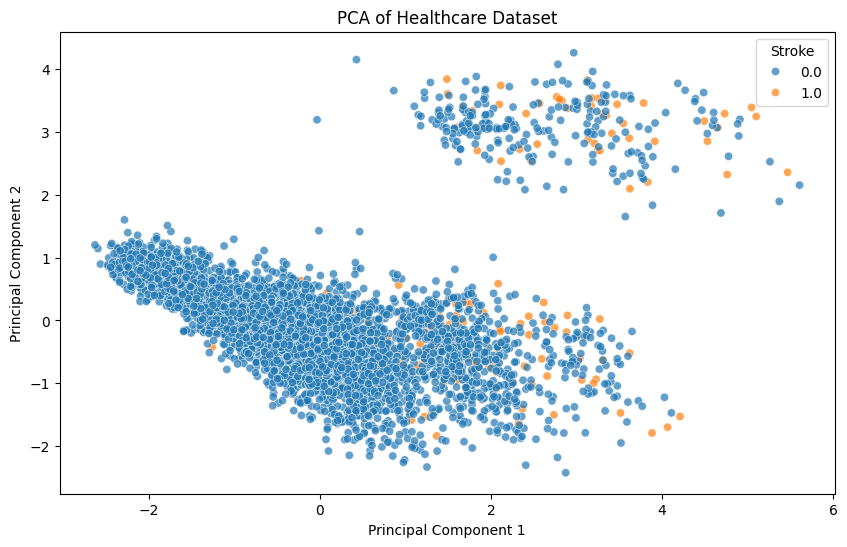

In [34]:
#Let's do some PCA to visualize the data in 2D
# we need to convert categorical variables to numerical ones
#Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered.drop(columns=['stroke']))
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['stroke'] = df_filtered['stroke'].values
# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='stroke', data=pca_df, alpha=0.7)
plt.title('PCA of Healthcare Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Stroke', loc='upper right')
plt.show()

In [35]:
print(pca.explained_variance_ratio_)

[0.36268262 0.19082931]


Using PCA is not useful here, classes are not sperated well as needed, we can use LDA for better visualization

C:\Users\ahmed\AppData\Local\Temp\ipykernel_9736\1692769423.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stroke', loc='upper right')


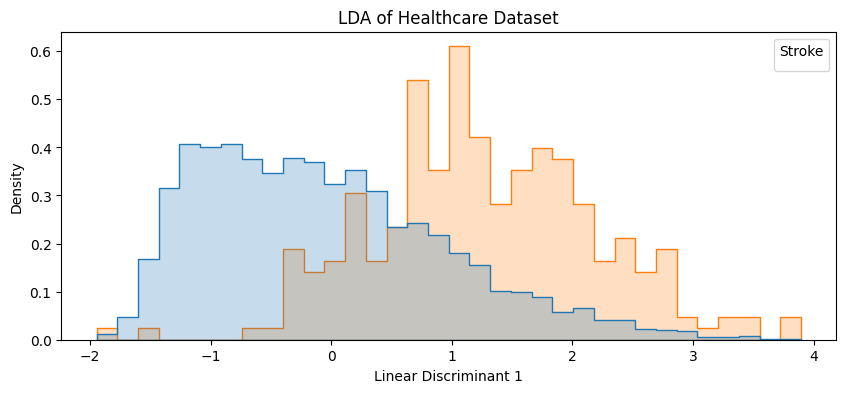

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Separate features and target
X = df_filtered.drop(columns=['stroke'])
y = df_filtered['stroke']

# Standardize the features
X_scaled = scaler.fit_transform(X)

# Apply LDA
lda = LDA(n_components=1)  # Only 1 component for binary classification
X_lda = lda.fit_transform(X_scaled, y)

# Create a DataFrame with the LDA result
lda_df = pd.DataFrame(data=X_lda, columns=['LD1'])
lda_df['stroke'] = y.values

# Plot the LDA result
plt.figure(figsize=(10, 4))
sns.histplot(data=lda_df, x='LD1', hue='stroke', element='step', stat='density', common_norm=False)
plt.title('LDA of Healthcare Dataset')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Density')
plt.legend(title='Stroke', loc='upper right')
plt.show()
df_encoded

Good insight, LDA showed that there's hardly any separabilty between the two classes

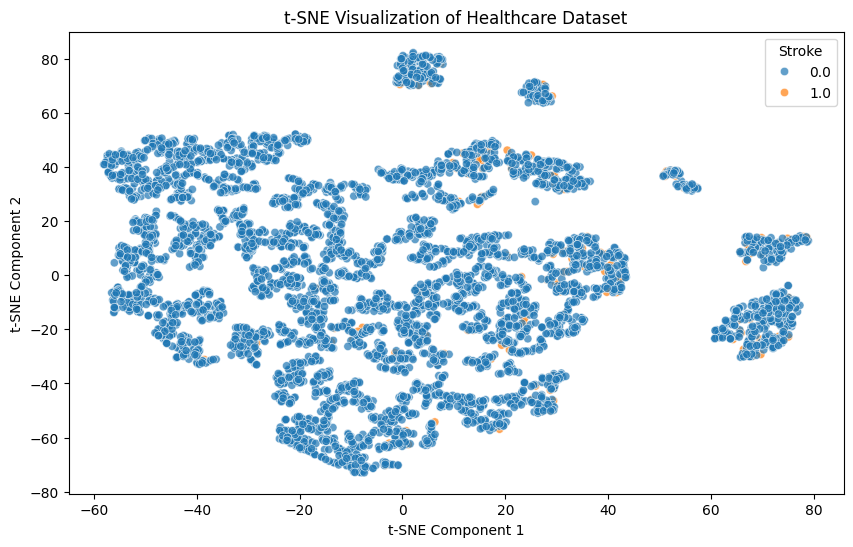

In [39]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Prepare the data
X = df_filtered.drop(columns=['stroke'])
y = df_filtered['stroke']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 3. Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['stroke'] = y.values

# 4. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='stroke', data=tsne_df, alpha=0.7)
plt.title('t-SNE Visualization of Healthcare Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Stroke')
plt.show()


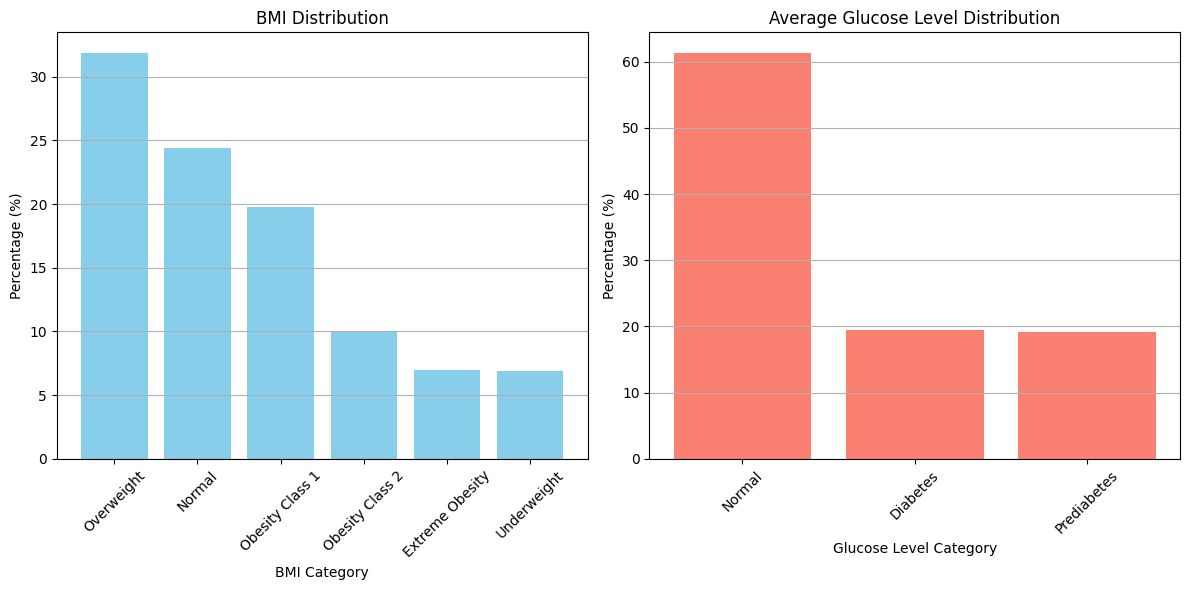

In [40]:
# let's plot avg glucose level and bmi if they are realistic according medical standards

# Define BMI categories
bmi_categories = pd.cut(df_cleaned['bmi'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                        labels=['Underweight', 'Normal', 'Overweight', 'Obesity Class 1', 'Obesity Class 2', 'Extreme Obesity'])

# Calculate BMI category percentages
bmi_distribution = bmi_categories.value_counts(normalize=True) * 100

# Define glucose level categories
glucose_categories = pd.cut(df_cleaned['avg_glucose_level'], bins=[0, 100, 125, float('inf')],
                            labels=['Normal', 'Prediabetes', 'Diabetes'])

# Calculate glucose level category percentages
glucose_distribution = glucose_categories.value_counts(normalize=True) * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(bmi_distribution.index.astype(str), bmi_distribution.values, color='skyblue')
plt.title('BMI Distribution')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.subplot(1, 2, 2)
plt.bar(glucose_distribution.index.astype(str), glucose_distribution.values, color='salmon')
plt.title('Average Glucose Level Distribution')
plt.xlabel('Glucose Level Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [41]:
#describe bmi and avg glucose level columns
df_cleaned[['bmi', 'avg_glucose_level']].describe(percentiles=[.25, .5, .75, .95, .99])


,bmi,avg_glucose_level
count,5049.000000,5049.000000
mean,28.541541,105.941353
std,6.984600,45.040273
min,10.300000,55.120000
25%,23.700000,77.240000
50%,28.300000,91.850000
75%,32.600000,113.950000
95%,41.560000,215.932000
99%,47.500000,240.762000
max,51.800000,271.740000


Naive Bayes

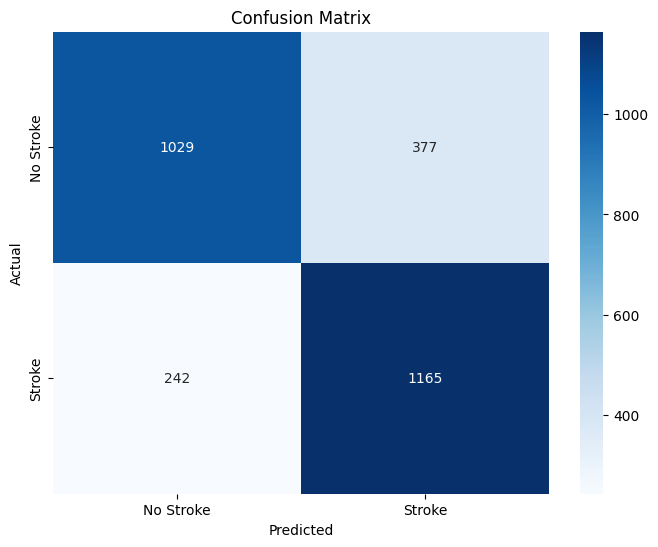


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      1406
         1.0       0.76      0.83      0.79      1407

    accuracy                           0.78      2813
   macro avg       0.78      0.78      0.78      2813
weighted avg       0.78      0.78      0.78      2813


Accuracy Score:
0.779950231070032


In [ ]:
# Import necessary libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare the data
X = df_filtered.drop(columns=['stroke'])  # Features
y = df_filtered['stroke']  # Target variable

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=57, stratify=y_resampled)

priors=[0.4, 0.6]
# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB(priors=priors)

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

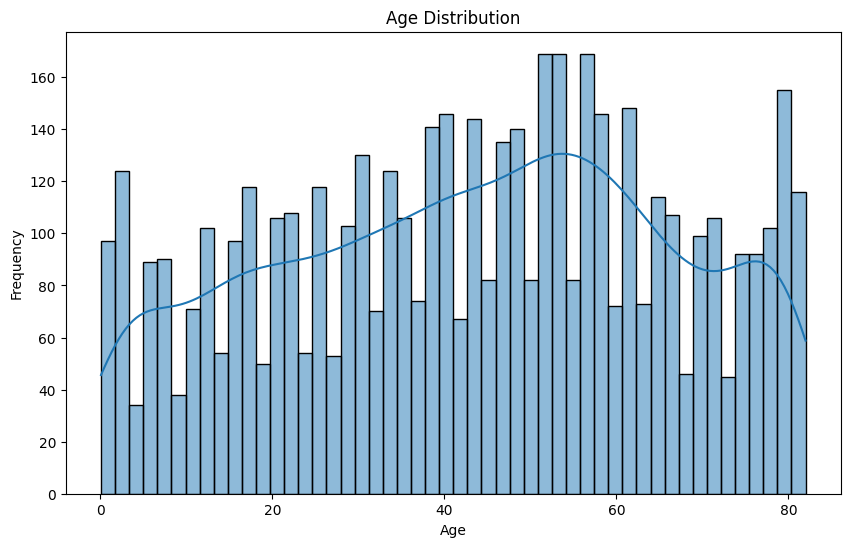

In [44]:
# plot age to check distribution

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['age'], bins=50, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_edit['age'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5), color='skyblue')

In [ ]:
#count total data for age less than 2
rows_less_2 = df_edit[df_edit['age'] < 5].shape[0]
print(f"Total people with age less than 2: {rows_less_2}")

In [ ]:
# #count total data for age less than 2 and have stroke
# age = 45
# rows_less_2_stroke = df_edit[(df_edit['age'] < age) & (df_edit['stroke'] > 0)].shape[0]
# print(f"Total people with age less than {age} and stroke: {rows_less_2_stroke}")


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_edit['gender'], bins=50)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_edit['gender'].value_counts()

Let's remove the "Other" gender, for safety

In [ ]:
# display the gender "Other" data

df_edit[df_edit['gender'] == 'Other'].head(10) 



In [ ]:
 #display class distribution
df_edit['stroke'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Stroke Class Distribution')

In [ ]:
df_edit['stroke'].value_counts()